# 1. 导包

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier,XGBRegressor
from sklearn import model_selection, metrics
from sklearn.model_selection import GridSearchCV # 网格搜索，交叉验证

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

# 2. 加载数据

In [2]:
train = pd.read_csv('train_modified.csv')
test = pd.read_csv('test_modified.csv')
display(train.head(),test.head())

,Disbursed,Existing_EMI,ID,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,Age,EMI_Loan_Submitted_Missing,...,Var2_2,Var2_3,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2
0,0.0,0.0,ID000002C20,300000.0,5.0,20000,1,0,37,1,...,0,0,0,0,1,1,0,1,0,0
1,0.0,0.0,ID000004E40,200000.0,2.0,35000,3,13,30,0,...,0,0,0,0,1,0,1,1,0,0
2,0.0,0.0,ID000007H20,600000.0,4.0,22500,1,0,34,1,...,0,0,0,0,0,0,1,0,0,1
3,0.0,0.0,ID000008I30,1000000.0,5.0,35000,3,10,28,1,...,0,0,0,0,0,0,1,0,0,1
4,0.0,25000.0,ID000009J40,500000.0,2.0,100000,3,17,31,1,...,0,0,0,0,0,0,1,0,0,1


,Existing_EMI,ID,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,Age,EMI_Loan_Submitted_Missing,Interest_Rate_Missing,...,Var2_2,Var2_3,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2
0,0.0,ID000026A10,100000.0,3.0,21500,3,3,28,0,0,...,0,0,0,0,0,0,1,1,0,0
1,0.0,ID000054C40,0.0,0.0,42000,5,8,35,0,0,...,1,0,0,0,0,0,1,0,1,0
2,0.0,ID000066O10,300000.0,2.0,10000,1,0,26,1,1,...,0,0,0,0,0,1,0,0,1,0
3,0.0,ID000110G00,0.0,0.0,14650,1,0,24,1,1,...,1,0,0,0,0,1,0,0,1,0
4,5000.0,ID000113J30,100000.0,1.0,23400,1,0,28,1,1,...,0,0,0,0,0,0,1,0,0,1


In [3]:
# 删除ID字段，对建模没有实际意义
train.drop(labels = 'ID',axis = 1,inplace = True)
test.drop(labels = 'ID',axis = 1,inplace = True)

# 声明训练数据字段和目标值字段
target = 'Disbursed'
cols = [x for x in train.columns if x not in [target]]
display(cols)

['Existing_EMI',
 'Loan_Amount_Applied',
 'Loan_Tenure_Applied',
 'Monthly_Income',
 'Var4',
 'Var5',
 'Age',
 'EMI_Loan_Submitted_Missing',
 'Interest_Rate_Missing',
 'Loan_Amount_Submitted_Missing',
 'Loan_Tenure_Submitted_Missing',
 'Processing_Fee_Missing',
 'Device_Type_0',
 'Device_Type_1',
 'Filled_Form_0',
 'Filled_Form_1',
 'Gender_0',
 'Gender_1',
 'Var1_0',
 'Var1_1',
 'Var1_2',
 'Var1_3',
 'Var1_4',
 'Var1_5',
 'Var1_6',
 'Var1_7',
 'Var1_8',
 'Var1_9',
 'Var1_10',
 'Var1_11',
 'Var1_12',
 'Var1_13',
 'Var1_14',
 'Var1_15',
 'Var1_16',
 'Var1_17',
 'Var1_18',
 'Var2_0',
 'Var2_1',
 'Var2_2',
 'Var2_3',
 'Var2_4',
 'Var2_5',
 'Var2_6',
 'Mobile_Verified_0',
 'Mobile_Verified_1',
 'Source_0',
 'Source_1',
 'Source_2']

# 3. 构建训练函数

In [4]:
def modelfit(model, dtrain, dtest, cols,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    # 训练数据交叉验证
    if useTrainCV:
        xgb_param = model.get_xgb_params() # 获取参数，model传入模型，传入时，给了一些参数
        # 声明数据
        xgb_train = xgb.DMatrix(dtrain[cols].values, label=dtrain[target].values)
        xgb_test = xgb.DMatrix(dtest[cols].values)
        
        # xgb.cv # 交叉验证，筛选了，XGBoost集成算法的数量，多少棵树
        cvresult = xgb.cv(xgb_param, xgb_train, num_boost_round = model.get_params()['n_estimators'], 
                          nfold=cv_folds,early_stopping_rounds = early_stopping_rounds, 
                          verbose_eval=False)
        
        
        # 设置了，最佳的集成算法的决策树数量
        # 例如给了500棵树，但120棵，足够
        print('最佳的集成算法数量：',cvresult.shape[0])
        model.set_params(n_estimators=cvresult.shape[0])  # 重新赋值，用最优的数量替代旧的
  
    # 建模
    model.fit(dtrain[cols], dtrain['Disbursed'],eval_metric='auc') # 二分类评价指标
  
    # 对训练集预测
    y_ = model.predict(dtrain[cols])
    proba_ = model.predict_proba(dtrain[cols])[:,1] # 获取正样本
  
    # 输出模型的一些结果
    print('该模型表现：')
    print('准确率 (训练集): %.4g' % metrics.accuracy_score(dtrain['Disbursed'],y_))
    print('AUC 得分 (训练集): %f' % metrics.roc_auc_score(dtrain['Disbursed'],proba_))
    
    # 特征重要性
    feature_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
    feature_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

# 4. 筛选最佳的模型数量

最佳的集成算法数量： 126


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


该模型表现：
准确率 (训练集): 0.9854
AUC 得分 (训练集): 0.900561


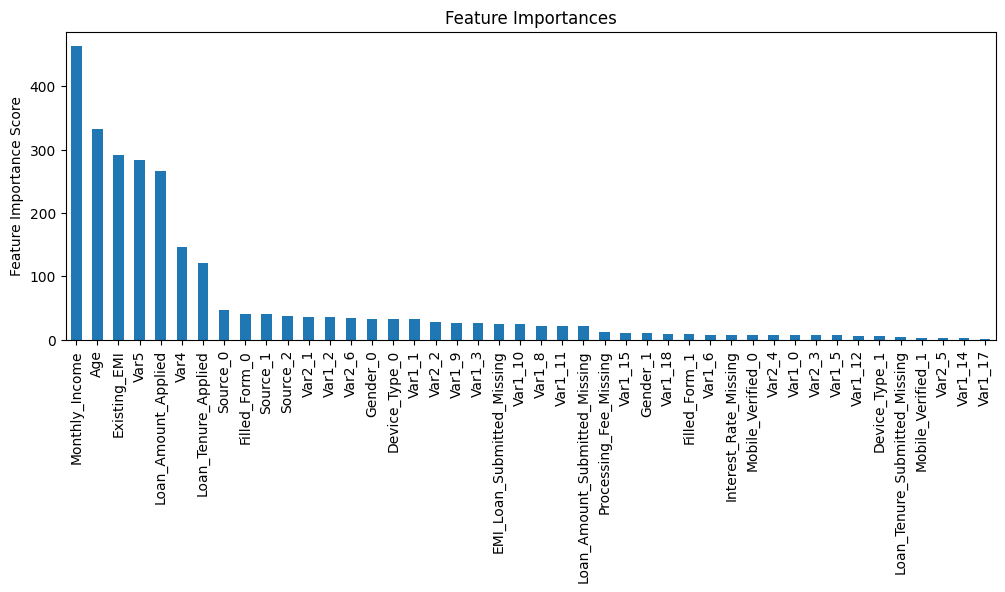

In [5]:
xgb1 = XGBClassifier(learning_rate =0.1,
                     use_label_encoder=False,
                     n_estimators=500,
                     max_depth=5,
                     min_child_weight=1,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective= 'binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     reg_alpha = 0,
#                      eval_metric=['error','auc'],
                     verbosity = 0)

modelfit(xgb1, train, test, cols)
# '''
# 该模型表现：
# 准确率 (训练集): 0.9854
# AUC 得分 (训练集): 0.867372
# '''

# 5. 网格搜索参数一筛选

In [6]:
# 对于max_depth和min_child_weight查找最好的参数
param_grid = { 'max_depth':range(3,10,2),# 3,5,7,9   先在一个大范围上筛选，然后再根据输出结果再来一轮一轮缩小范围
              'min_child_weight':range(1,6,2)} # 1,3,5

model = XGBClassifier(learning_rate =0.1,n_estimators=100,max_depth=5,use_label_encoder=False,
                      min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,
                      objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=27,
                      verbosity = 0)

#关键：声明了GridSearchCV
gsearch1 = GridSearchCV(estimator = model,param_grid = param_grid, 
                        scoring='roc_auc',   # roc-auc是分类的一个评价指标
                        n_jobs=-1,  # 开启多线程
                        cv=5) 

gsearch1.fit(train[cols],train[target])

print('本次筛选最佳参数：',gsearch1.best_params_)
print('最佳得分是：',gsearch1.best_score_)
# '''
# 本次筛选最佳参数： {'max_depth': 5, 'min_child_weight': 3}
# 最佳得分是： 0.8417229752667561
# '''


本次筛选最佳参数： {'max_depth': 5, 'min_child_weight': 5}
最佳得分是： 0.8420221449319427


# 6. 网格搜索参数二筛选

In [7]:
%%time
# 筛选合适的gamma：惩罚项系数，指定节点分裂所需的最小损失函数下降值
param_grid = {'gamma':[i/10.0 for i in range(0,5)]}

model = XGBClassifier(learning_rate =0.1,n_estimators=100,max_depth=5,use_label_encoder=False,
                      min_child_weight=3,gamma=0,subsample=0.8,colsample_bytree=0.8,
                      objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=27,
                      verbosity = 0)

gsearch2 = GridSearchCV(estimator = model,param_grid = param_grid,
                        scoring='roc_auc',n_jobs=4, cv=5)

gsearch2.fit(train[cols],train[target])

print('本次筛选最佳参数：',gsearch2.best_params_)
print('最佳得分是：',gsearch2.best_score_)

本次筛选最佳参数： {'gamma': 0.1}
最佳得分是： 0.8410242211226588
CPU times: total: 5.09 s
Wall time: 26.6 s


# 7. 参数三筛选

In [8]:
%%time
# 对subsample 和 colsample_bytree用grid search寻找最合适的参数
param_grid = {'subsample':[i/10.0 for i in range(6,10)],
              'colsample_bytree':[i/10.0 for i in range(6,10)]}

model = XGBClassifier(learning_rate =0.1,n_estimators=100,max_depth=5,use_label_encoder=False,
                      min_child_weight=3,gamma=0,subsample=0.8,colsample_bytree=0.8,
                      objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=1024,
                      verbosity = 0)

gsearch3 = GridSearchCV(estimator = model,param_grid = param_grid,
                        scoring='roc_auc',n_jobs=-1,cv=5)

gsearch3.fit(train[cols],train[target])

print('本次筛选最佳参数：',gsearch3.best_params_)
print('最佳得分是：',gsearch3.best_score_)

本次筛选最佳参数： {'colsample_bytree': 0.7, 'subsample': 0.9}
最佳得分是： 0.8420426760985134
CPU times: total: 5.67 s
Wall time: 1min 14s


# 8. 参数四筛选

In [9]:
%%time
# 对reg_alpha用grid search寻找最合适的参数
param_grid = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}

model = XGBClassifier(learning_rate =0.1,n_estimators=100,max_depth=5,use_label_encoder=False,
                      min_child_weight=3,gamma=0,subsample=0.8,colsample_bytree=0.8,
                      objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=1024,
                      verbosity = 0)

gsearch4 = GridSearchCV(estimator = model,param_grid = param_grid,
                        scoring='roc_auc',n_jobs=-1,cv=5)

gsearch4.fit(train[cols],train[target])

print('本次筛选最佳参数：',gsearch4.best_params_)
print('最佳得分是：',gsearch4.best_score_)

本次筛选最佳参数： {'reg_alpha': 1}
最佳得分是： 0.8418440004437742
CPU times: total: 5.02 s
Wall time: 24.4 s


# 9. 最佳参数融合

最佳的集成算法数量： 124


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


该模型表现：
准确率 (训练集): 0.9854
AUC 得分 (训练集): 0.894746


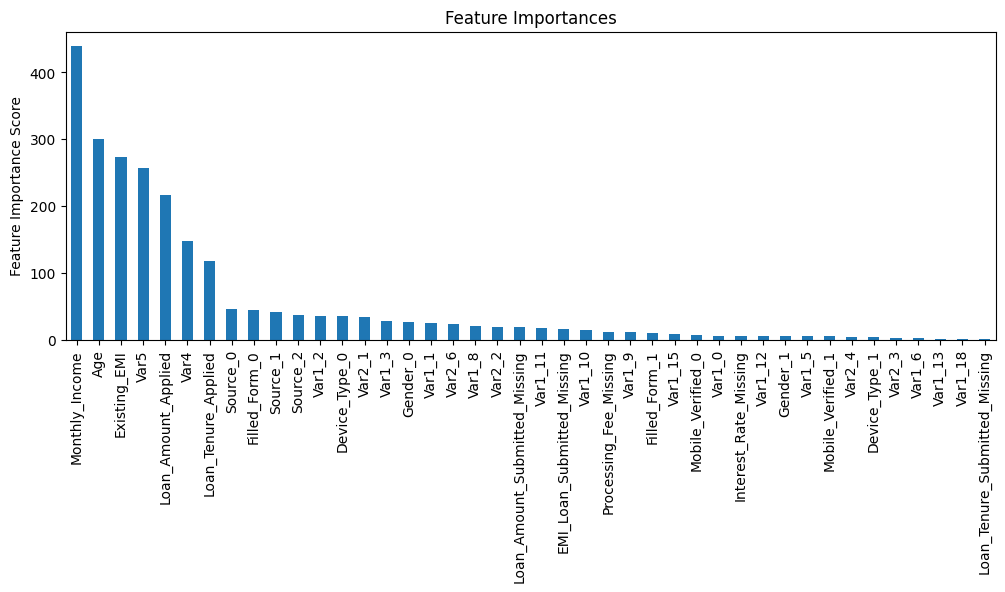

In [10]:
xgb2 = XGBClassifier(learning_rate =0.1,
                     use_label_encoder=False,
                     n_estimators=124,
                     max_depth=5,
                     min_child_weight=3,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     reg_alpha = 1,
                     objective= 'binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
#                      eval_metric=['error','auc'],
                     verbosity = 0)
modelfit(xgb2, train, test, cols)

# 对比没有使用最佳参数，输出结果没有提升，反而下降了，说明XGBoost默认参数已经很好了

# 10. 调整学习率

最佳的集成算法数量： 100


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


该模型表现：
准确率 (训练集): 0.9855
AUC 得分 (训练集): 0.910933


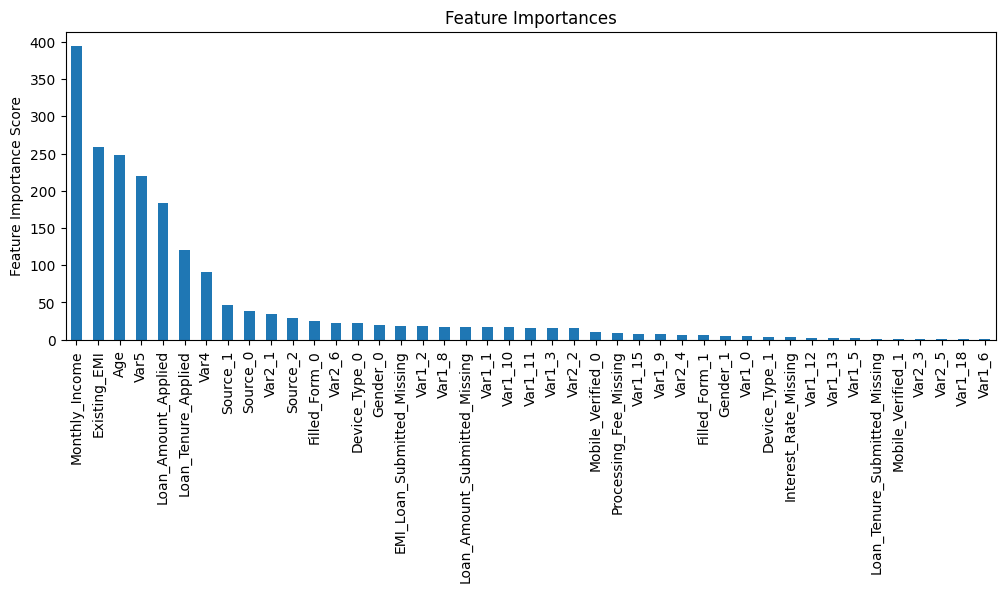

In [11]:
xgb3 = XGBClassifier(learning_rate =0.2,  # 前面设置的0.1
                     use_label_encoder=False,
                     n_estimators=100,
                     max_depth=5,
                     min_child_weight=3,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     reg_alpha = 1,
                     objective= 'binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
#                      eval_metric=['error','auc'],
                     verbosity = 0)
modelfit(xgb3, train, test, cols)